In [1]:
from arch import arch_model
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import datetime as datetime

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

The purpose of this notebook is to analyze a financial time series using various time series techniques, with the goal of forecasting future values. The time series data is the closing stock price of Amazon shares for the past 20 years.

# Table of Contents <a id = 'ToC'></a>

- Data overview [1](#overview)

- High level analysis [2](#eda)

- GARCH model analysis [3](#garch)

# Data overview [Return](#ToC) <a id = 'overview'></a>

In [2]:
data = pd.read_csv('Amazon_time_series.csv')

In [3]:
data.head()

,Date,Adj Close
0,5/15/1997,1.958333
1,5/16/1997,1.729167
2,5/19/1997,1.708333
3,5/20/1997,1.635417
4,5/21/1997,1.427083


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5088 non-null   object 
 1   Adj Close  5088 non-null   float64
dtypes: float64(1), object(1)
memory usage: 79.6+ KB


The data contains daily closing stock prices for Amazon, with no missing valaues. The dtype of the data columns will need to be adjusted.

In [5]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

Text(0, 0.5, 'Closing stock price')

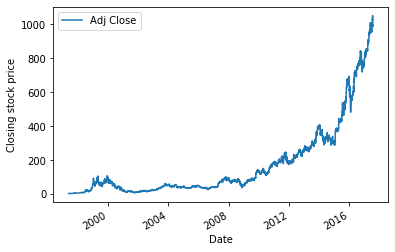

In [6]:
data.plot(x = 'Date', y = 'Adj Close')
plt.ylabel('Closing stock price')

When forecasting stocks, the raw price of the stock is not the feature of interest. We want to know whether the stock price will increase or decrease relative to its current value. With this is mind we will look at the precentage change in the stock values.

In [7]:
data['return'] = data['Adj Close'].pct_change()
data = data.dropna()

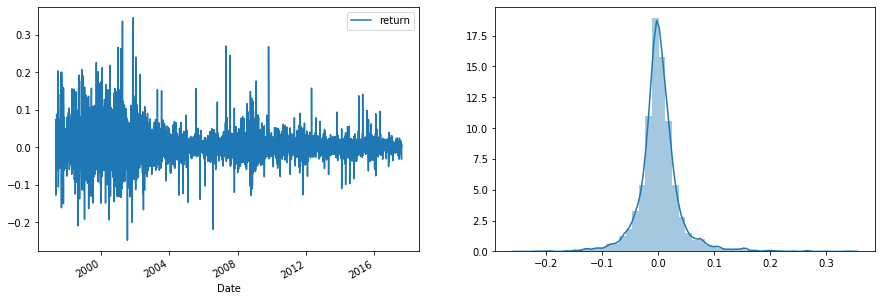

In [8]:
f, axes = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(15)
data.plot(x = 'Date', y = 'return', ax = axes[0])
sns.distplot(data['return'].values, ax = axes[1])

# High level analysis [Return](#ToC) <a id = 'eda'></a>

In this section, we perform various statistical tests to gain insights into the data we will forecast.

In [9]:
def plot_correlations(data):
    f, axes = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = plot_acf(x = data, ax = axes[0], zero = False)
    _ = plot_pacf(x = data, ax = axes[1], zero = False)

In [10]:
print(f'ADF results: {adfuller(x = data["return"].values)[1]}')
print(f'KPSS results: {kpss(x = data["return"].values)[1]}')

ADF results: 2.5655898083485823e-22
KPSS results: 0.07657695817061705


C:\Users\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


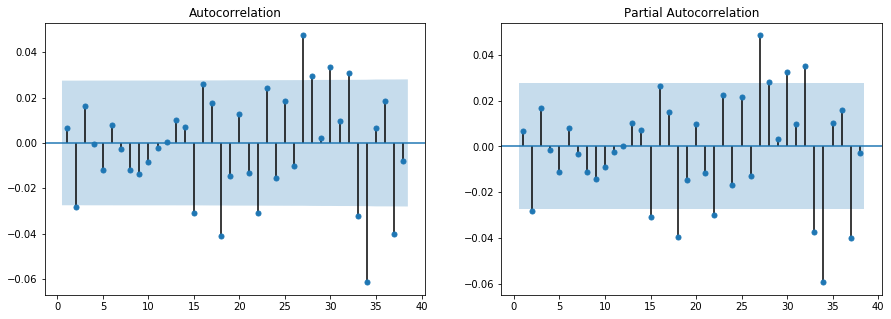

In [11]:
plot_correlations(data['return'].values)

There is no underlying correlation or trend in the mean of the returns data.

# GARCH model [Return](#ToC) <a id = 'garch'></a>

Due to the time series exhibiting heteroskedascity, a GARCH model will be employed.

In [12]:
split = int(0.8 * len(data))
data_train = data.iloc[:split, :]
data_test = data.iloc[split:, :]

# We will perform a parameter scan with temporal cross-validation to find the best fitting model
all_parameters = list(product(*[np.arange(1, 3), np.arange(0, 3), np.arange(1, 3), ['normal', 't']]))
tscv = TimeSeriesSplit()

In [13]:
overall_bic = []
for iteration, parameter in enumerate(all_parameters):
    bic = []
    mse = []
    for train_index, test_index in tscv.split(data_train):
        X_train, X_test = data_train.iloc[train_index, 0], data_train.iloc[test_index, 0]
        y_train, y_test = data_train.iloc[train_index, 1], data_train.iloc[test_index, 1]
        garch = arch_model(y_train.values, p = int(parameter[0]),
                                                  o = int(parameter[1]), 
                                                  q = int(parameter[2]), dist = parameter[3])
        results = garch.fit(disp = 'off')
        bic.append(results.bic)
    overall_bic.append(bic)

In [14]:
bic_df = pd.DataFrame(overall_bic)
bic_df['mean_bic'] = np.median(bic_df, axis = 1)

In [15]:
bic_df.idxmin()

0           0
1           0
2           2
3           0
4           0
mean_bic    2
dtype: int64

In [16]:
all_parameters[0]

(1, 0, 1, 'normal')

For most of the folds a simple GARCH(1, 1) model is the model in best agreement with the data, and so this arrangement will be used.

In [43]:
final_garch = arch_model(data_train['return'].values * 10, p = 1, q = 1, dist = 'normal')
res = final_garch.fit(disp = 'off')

In [44]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1628.88
Distribution:                  Normal   AIC:                           3265.77
Method:            Maximum Likelihood   BIC:                           3291.01
                                        No. Observations:                 4069
Date:                Fri, Nov 13 2020   Df Residuals:                     4065
Time:                        15:38:32   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0168  5.173e-03      3.250  1.155e-03 [6.673e-03,2.695e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.7026e-04  2.309e-03      0.420      0.674 [-3.555e-03,5.496e-03]
alpha[1]       0.0235  3.904e-02      0.602      0.547   [-5.304e-02,  0.100]
beta[1]        0.9692  5.360e-02     18.084  4.298e-73      [  0.864,  1.074]
=============================================================================

Covariance estimator: robust
"""

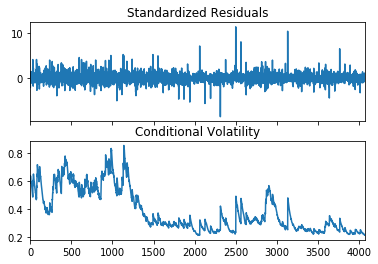

In [45]:
_ = res.plot()

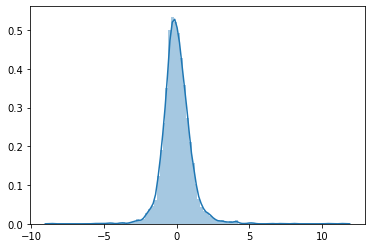

In [46]:
standardised_residuals = res.resid / res.conditional_volatility
sns.distplot(standardised_residuals, bins = 100)

p-value of adf test: 0.0


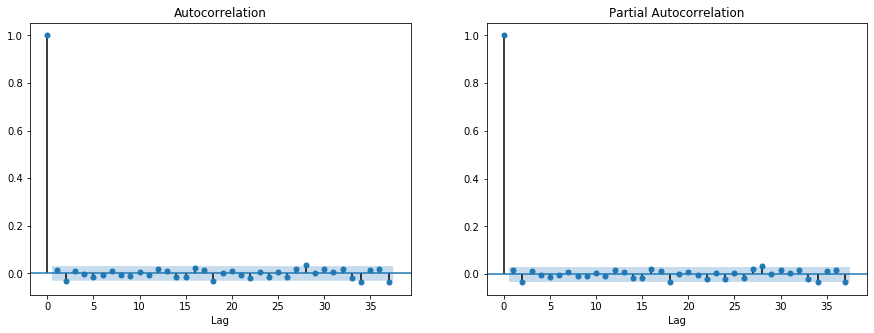

In [47]:
f, axes = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(15)
_ = plot_acf(x = standardised_residuals, ax = axes[0])
_ = plot_pacf(x = standardised_residuals, ax = axes[1])
axes[0].set_xlabel('Lag')
axes[1].set_xlabel('Lag')

print(f'p-value of adf test: {adfuller(standardised_residuals)[1]}')

There is no autocorrelation or unit root in the residuals, and the distribution is approximately normal. I conclude that this model is a reasonable fit to the data.

# Use case: Evaluate model VaR

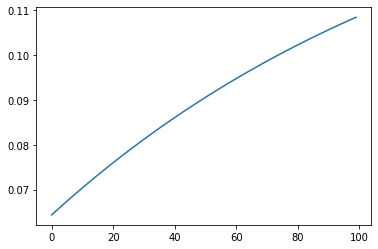

In [49]:
gm_forecast = res.forecast(horizon = 100)
plt.plot(gm_forecast.mean.iloc[-1, :].values + gm_forecast.variance.iloc[-1, :].values)